# Covid-19 Prediction Model Project

# Introduction

**Purpose of Project**

In this hackathon, we want you to build machine learning models to predict COVID-19 infections from symptoms. It has several applications – for example, triaging patients to be attended by a doctor or nurse, recommending self-isolation through contact tracing apps, etc.

**Problem Statement**

This is a classifier problem as we want to either:
1. Predict the test result from our features
2. Predict the likihood of a positive result from our features

We might also want to consider who is at greater risk. For example,
* Risk of complications is more likely in over 60s
* A shortness of breath might be a more worrying symptom than sore throat

# Notes for Simone

## Data Exploration

* We replaced nulls with 'missing' as there was no clear method to impute the nulls - we could then one hot encoding for these missing values
* Trending over time on positive corona virus tests shows that cough, fever and males were more likely to have positive results and increased over time. 
* Other sypmtoms were less liekly to result in a positive test and became less important over time
* There was only 2 months of data - we decided to use a day, weekday and month variable
* We stratified on y to ensure we had an equal distribution of positives across train and test
* In the logisitc regression model we found a high accuracy score but this was more linked to the high number of negative results
    * The recall score for positives was 0.51. So we are only going to identify half of positives cases
    * We are using an oversampling and smote method to assist in increasing the models exposure to positive tests

### Next steps

* Create a better performing model - using a decision tree (from the sucess of Ben's model)
* Implement SMOTE and Oversampling techniques
* Fine tune the model using GridSearch etc.
* Use an ensemble method to improve the performance of the final model
* Ensure we do not have model bias once complete?

## Libraries
As always, we'll start by importing the necessary libraries.

In [22]:
# It's good practice to add comments to explain your code 
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [23]:
# Add your code here
data = pd.read_csv('data/corona_tested_individuals_ver_006.english.csv', dtype={'age_60_and_above': str})
data['test_date'] = pd.to_datetime(data['test_date'] )

data['test_day'] = data['test_date'].dt.day
data['test_weekday'] = data['test_date'].dt.weekday
data['test_month'] = data['test_date'].dt.month

data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,test_day,test_weekday,test_month
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other,30,3,4
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other,30,3,4
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,NaN,male,Other,30,3,4
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other,30,3,4
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other,30,3,4


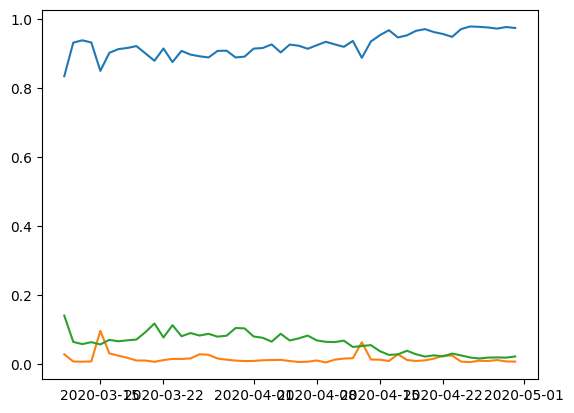

In [24]:
# what is the trend of results over time?

test = data.pivot_table(index = ['test_date'], 
                        columns = ['corona_result'], 
                        values = ['test_indication'], 
                        aggfunc = 'count' , margins = 'all')

test.columns = ['neg','pos','other','all']

test.head()
test = test.iloc[:-1,:]
test['perc_neg'] = test['neg'] / test['all']
test['perc_pos'] = test['pos'] / test['all']
test['perc_other'] = test['other'] / test['all']
test.head()
plt.plot(test['perc_neg'])
plt.plot(test['perc_pos'])
plt.plot(test['perc_other'])
plt.show()        



**Question 1**

Descibe the dataset

- There are 278,848 observations

Exploratory Data Analysis

Think about possible biases and limitations of this dataset. What are the sources of uncertainty?
* What is the format of feature values?
* What is the statistics of these feature values? How many symptoms are reported or not?
* Which symptoms have a reporting bias, i.e., likely to be reported when the patient is COVID positive?
* How will the symptoms with reporting bias affect the model’s performance?
* Visualization: Draw the bar graph of features grouped by the target class?
* What does the bar graph of the symptoms with reporting bias look like?
* Determine if we have a class imbalance in the dataset? If so, what do you reckon will be the downstream challenges in evaluating the model? How will you overcome those challenges?

In [25]:
# data.info()

In [26]:
# data.isna().sum()

## Observations

| Columns            | dtype    | Null Count | Thoughts |
|--------------------|----------|------------|----------|
| test_date          |  datetime|           0| We should look at the trending over time and if that effects result|
| cough              |   float  |         252| Binary classifer. Dropping 252 records might impact the model accuracy - use a 'missing' value and one hot encode|
| fever              |    float |         252| Same as 'cough'|
| sore_throat        |    float |           1| Binary classifer; As the volume of nulls is low, we can drop the null record|
| shortness_of_breath|  float   |           1| Same as sore_throat|
| head_ache          |   float  |           1| Same as sore_throat|
| corona_result      |   object |           0| The y values: 93% negatives so need to be careful here on model bias|
| age_60_and_above   | object   |      127320| Binary, we could change to categorical: under 60, over 60 and missing |
| gender             | object   |       19563| Binary classifier, and will add a 'missing' into a one hot encoder|
| test_indication    |  object  |           0| Categorical - one hot encode|

* There are 278,848 observations
* We need to look at the null data within the positive dataset to see how much of an impact the null values have on the result
* We considered imputing on our null values but decided it would be better to add a missing category
* We will either SMOTE and / or over sample on our positive results to address imbalance


In [27]:
# what about cough?

test = data.groupby(['cough','corona_result'], dropna = False).size().reset_index(name = 'count')
test['result_sum'] = test.groupby(['corona_result'], dropna = False)['count'].transform('sum')
test['result_perc'] = round(test['count'] / test['result_sum'] * 100, 2)
test[test['corona_result']=='positive']
# print('''
# Observation:
# * ''')

,cough,corona_result,count,result_sum,result_perc
2,0.0,positive,8112,14729,55.08
5,1.0,positive,6584,14729,44.70
7,NaN,positive,33,14729,0.22


In [28]:
# Pre-Processing
# remove nulls from sore_throat, shortness_of_breath and head_ache as there will be little impact on the outcome
df = data.copy()
df = df.dropna(subset=['sore_throat', 'shortness_of_breath', 'head_ache'])
df.isna().sum()

test_date                   0
cough                     251
fever                     251
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age_60_and_above       127319
gender                  19562
test_indication             0
test_day                    0
test_weekday                0
test_month                  0
dtype: int64

In [29]:
# now one hot encode age 60 and gender
df['age_60_and_above'] = df['age_60_and_above'].fillna('missing')
df['gender'] = df['gender'].fillna('missing')
df['cough'] = df['cough'].fillna('missing')
df['fever'] = df['fever'].fillna('missing')

one_hot_encoded_data = pd.get_dummies(df, columns = ['age_60_and_above','gender','cough','fever','test_indication'])
#display(one_hot_encoded_data.sample(10))
one_hot_encoded_data.isna().sum()

test_date                                 0
sore_throat                               0
shortness_of_breath                       0
head_ache                                 0
corona_result                             0
test_day                                  0
test_weekday                              0
test_month                                0
age_60_and_above_No                       0
age_60_and_above_Yes                      0
age_60_and_above_missing                  0
gender_female                             0
gender_male                               0
gender_missing                            0
cough_0.0                                 0
cough_1.0                                 0
cough_missing                             0
fever_0.0                                 0
fever_1.0                                 0
fever_missing                             0
test_indication_Abroad                    0
test_indication_Contact with confirmed    0
test_indication_Other           

In [30]:
# test results being 'other' did not provide a useful outcome so we are removing
one_hot_encoded_data = one_hot_encoded_data[one_hot_encoded_data['corona_result']!='other'].reset_index(drop = True)

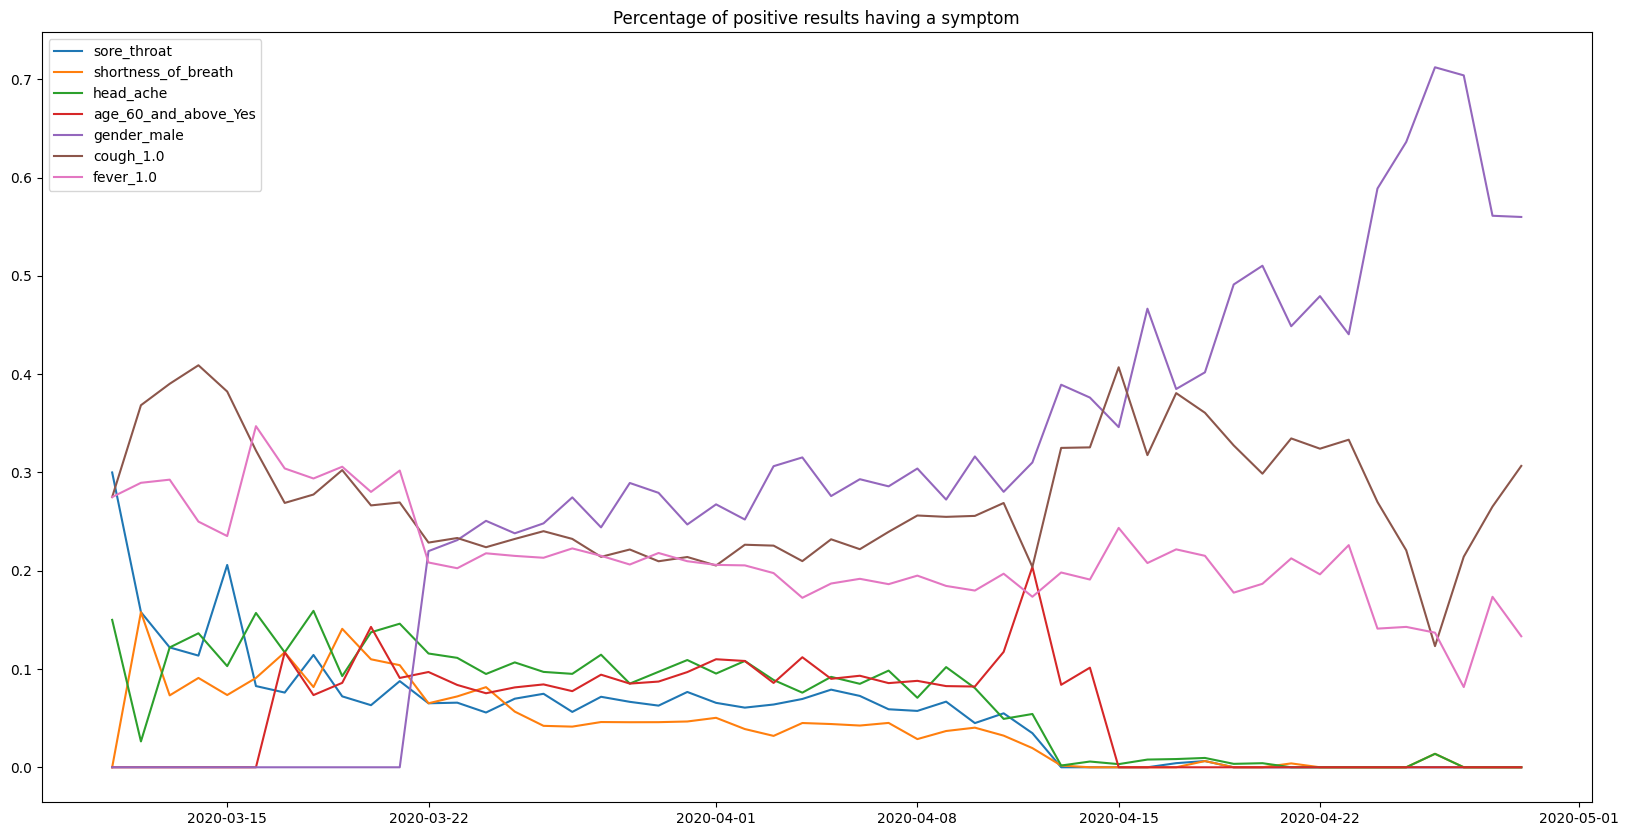


Above shows that 
* positive results have a high prevelence of cough and fever symptoms
* cough symptoms incraesed over time resulting in a positive test
* positive results were more likely in males which increased over time
* other symptoms did not result in as many postive tests and reduced over time



In [31]:
# for each feature do we see a change in positive results over time?

test = one_hot_encoded_data[one_hot_encoded_data['corona_result']=='positive']

test_vals = ['sore_throat', 
             'shortness_of_breath', 
             'head_ache',
             #'age_60_and_above_No', 
             'age_60_and_above_Yes',
             #'age_60_and_above_missing', 
             #'gender_female', 
             'gender_male',
             #'gender_missing',
             #'cough_0.0', 
             'cough_1.0', 
             #'cough_missing',
             #'fever_0.0', 
             'fever_1.0', 
             #'fever_missing', 
             #'test_indication_Abroad',
             #'test_indication_Contact with confirmed', 
             #'test_indication_Other'
            ]

test = test.pivot_table(index = 'test_date', values = test_vals, aggfunc = 'sum')
test['total'] = test.sum(axis=1, numeric_only=True)

test = test.iloc[:-1,:]

for c in test_vals:
    test[c] = test[c] / test['total']

plt.figure(figsize = (20,10))
for c in test_vals:
    plt.plot(test[c])
plt.legend(test_vals)
plt.title('Percentage of positive results having a symptom')
plt.show()

print('''
Above shows that 
* positive results have a high prevelence of cough and fever symptoms
* cough symptoms incraesed over time resulting in a positive test
* positive results were more likely in males which increased over time
* other symptoms did not result in as many postive tests and reduced over time
''')


## Baseline model




In order to compare a model, we will create a baseline model using logistic regression

In [36]:
X = one_hot_encoded_data.drop(columns = ['corona_result','test_date'])
y = one_hot_encoded_data['corona_result']

In [38]:
X.head()

,sore_throat,shortness_of_breath,head_ache,test_day,test_weekday,test_month,age_60_and_above_No,age_60_and_above_Yes,age_60_and_above_missing,gender_female,...,gender_missing,cough_0.0,cough_1.0,cough_missing,fever_0.0,fever_1.0,fever_missing,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
0,0.0,0.0,0.0,30,3,4,False,False,True,True,...,False,True,False,False,True,False,False,False,False,True
1,0.0,0.0,0.0,30,3,4,False,False,True,True,...,False,False,True,False,True,False,False,False,False,True
2,0.0,0.0,0.0,30,3,4,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
3,0.0,0.0,0.0,30,3,4,False,False,True,True,...,False,False,True,False,True,False,False,False,False,True
4,0.0,0.0,0.0,30,3,4,False,False,True,False,...,False,False,True,False,True,False,False,False,False,True


In [39]:
y

0         negative
1         negative
2         negative
3         negative
4         negative
            ...   
274950    negative
274951    negative
274952    negative
274953    positive
274954    negative
Name: corona_result, Length: 274955, dtype: object

In [61]:
pd.DataFrame({'feature':[c], 'corr':[corr]})

,feature,corr
0,sore_throat,0.278376


In [63]:
corr_result = pd.DataFrame(columns = ['feature','corr'])
corr_result

,feature,corr


In [65]:
# Do we have a correlation between our target variable and each feature?
y_binary = y.replace({'negative': 0, 'positive': 1})

# Initialize an empty list to collect results
corr_results = []

# Calculate correlation for each feature
for c in X.columns:
    corr = X[c].corr(y_binary)
    print(f'Correlation of {c} with target: {corr}')
    corr_results.append({'feature': c, 'corr': corr})

# Create a DataFrame from the results
corr_result = pd.DataFrame(corr_results)

Correlation of sore_throat with target: 0.2783756218088007
Correlation of shortness_of_breath with target: 0.23330315685740766
Correlation of head_ache with target: 0.36723872600507185
Correlation of test_day with target: -0.027276935867964872
Correlation of test_weekday with target: -0.003917840392236812
Correlation of test_month with target: -0.08624625227847946
Correlation of age_60_and_above_No with target: 0.08538556686174079
Correlation of age_60_and_above_Yes with target: 0.046955747983369385
Correlation of age_60_and_above_missing with target: -0.11258762395439437
Correlation of gender_female with target: -0.027334179228201815
Correlation of gender_male with target: 0.02255919424934285
Correlation of gender_missing with target: 0.009409680213684964
Correlation of cough_0.0 with target: -0.1968188383043649
Correlation of cough_1.0 with target: 0.1964692849210577
Correlation of cough_missing with target: 0.009924502279694901
Correlation of fever_0.0 with target: -0.26597547679937

In [67]:
corr_result.sort_values(by='corr', ascending = False)

,feature,corr
19,test_indication_Contact with confirmed,0.570057
2,head_ache,0.367239
0,sore_throat,0.278376
16,fever_1.0,0.266281
1,shortness_of_breath,0.233303
13,cough_1.0,0.196469
6,age_60_and_above_No,0.085386
7,age_60_and_above_Yes,0.046956
18,test_indication_Abroad,0.029508
10,gender_male,0.022559


In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size= 0.8 ,stratify = y)

In [13]:
print(set(y_train))
print(set(y_test))

In [14]:
lr = LogisticRegression()

In [15]:
lr.fit(X_train, y_train)

In [16]:
y_pred = lr.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy:', accuracy)

This looks really good! But what about against each result?

In [47]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True, fmt = '.2%', cmap = 'Blues')

In [23]:
class_report = classification_report(y_test, y_pred)
print(class_report)

In [38]:
feature_importance = pd.DataFrame({'Feature': X.columns,
                                  'Importance': lr.coef_[0]}).sort_values(by = 'Importance', 
                                                                          ascending = False)

top_features = feature_importance.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the feature with the highest importance at the top
plt.show()
top_features

In [25]:
# lets one hot encode age_60_and_above to '60_and_above', 'under_60', 'unknown'

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define preprocessing steps
preprocessor = StandardScaler()

# Define the model
model = LogisticRegression()

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Assume X_train and y_train are your data
# pipeline.fit(X_train, y_train)

In [26]:
for c in data.columns[1:]:
    print(c)
    if c == 'corona_result':
        pass
    else:
        plt.title(c)
        for a in one_hot_encoded_data.corona_result.unique():
            try:
                plt.hist(one_hot_encoded_data[one_hot_encoded_data.corona_result == a][c], bins = 2)
            except:
                pass
        plt.show()
    